In [1]:
library(CellChat)
library(anndata)
library(patchwork)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [13]:
ad <- read_h5ad("/home/wu/datb1/reseq_ppp/interaction_data/merged_normalised_log_counts.h5ad")
# access count data matrix
counts <- t(as.matrix(ad$X))
data.input <- as(counts, "dgCMatrix")

# access meta data
meta <- ad$obs
meta$labels <- meta[["leiden"]] 
# save the data for CellChat analysis
# save(data.input, meta, file = "interaction_data/cellchat_data.RData")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.7 GiB”


In [3]:
meta$sample <- meta[['Meta']]

In [4]:
rm(counts)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4487908,239.7,8593322,459.0,6762543,361.2
Vcells,118597783,904.9,1734031136,13229.7,1916141232,14619.0


In [5]:
# map cell types to the cell type e.g. "T cells" -> "Tcl"
meta$labels = abbreviate(meta$labels)

In [6]:
meta$labels %>% table()

.
B_C_ B_L_ CDTc Cldc Ecgc HlTc INHM Lngc Lyec Mcrp Mstc Nern Pldc PPPn Prif RgTc 
8197 2924 1272  602  721 5546  751 1901   55 1112 1146  387  170 3529 1012  671 
S_C_ S_L_ Scpf Scrf Vec1 Vec2 Vsmc 
5863 3374 2270  192 2992  499 2844 

In [7]:
cell.order = c('B_C_', 'B_L_','S_C_','S_L_','PPPn','CDTc','RgTc','HlTc','Cldc','Pldc','INHM','Lngc','Mstc','Mcrp','Ecgc','Lyec','Nern','Prif','Scpf','Scrf','Vec1','Vec2','Vsmc')

In [8]:
control_subset <- meta$Meta == "Control"
lesion_subset <- meta$Meta == "Lesion"

In [9]:
control_data <- data.input[, control_subset]
lesion_data <- data.input[, lesion_subset]

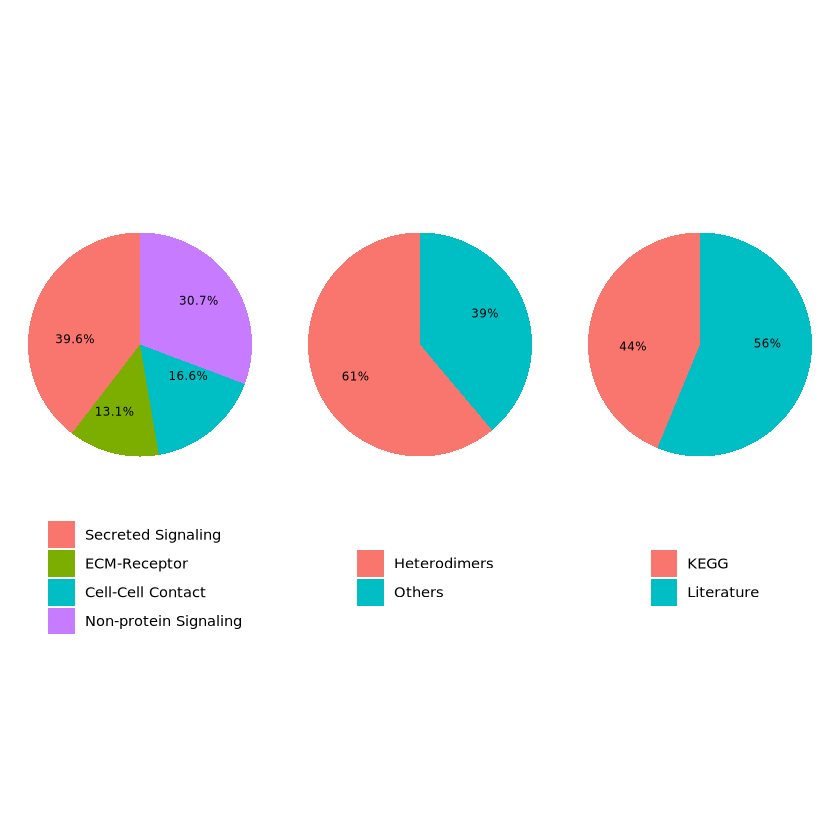

In [10]:
CellChatDB <- CellChatDB.human
showDatabaseCategory(CellChatDB)
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling

In [11]:
cellchat_control <- createCellChat(object = control_data, meta = meta[control_subset,], group.by = "labels")

# use a subset of CellChatDB for cell-cell communication analysis

# set the used database in the object
cellchat_control@DB <- CellChatDB.use
# subset the expression data of signaling genes for saving computation cost
cellchat_control <- subsetData(cellchat_control) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat_control <- identifyOverExpressedGenes(cellchat_control)
cellchat_control <- identifyOverExpressedInteractions(cellchat_control)
#> The number of highly variable ligand-receptor pairs used for signaling inference is 692
cellchat_control <- computeCommunProb(cellchat_control, type = "truncatedMean", trim = 0.05, population.size = TRUE)

[1] "Create a CellChat object from a data matrix"


Warning message in createCellChat(object = control_data, meta = meta[control_subset, :
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B_C_, CDTc, Cldc, Ecgc, HlTc, INHM, Lngc, Lyec, Mcrp, Mstc, Nern, Pldc, PPPn, Prif, RgTc, S_C_, Scpf, Scrf, Vec1, Vec2, Vsmc 
The number of highly variable ligand-receptor pairs used for signaling inference is 777 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-05-27 15:32:01.777673]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-05-27 17:23:24.260425]"


In [12]:
cellchat_control <- filterCommunication(cellchat_control, min.cells = 100)
cellchat_control <- computeCommunProbPathway(cellchat_control)
cellchat_control <- aggregateNet(cellchat_control)

The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  INHM, Lyec, Pldc, PPPn ! 	29.5% interactions are removed!


In [13]:
cellchat_lesion <- createCellChat(object = lesion_data, meta = meta[lesion_subset,], group.by = "labels")

# use a subset of CellChatDB for cell-cell communication analysis

# set the used database in the object
cellchat_lesion@DB <- CellChatDB.use
# subset the expression data of signaling genes for saving computation cost
cellchat_lesion <- subsetData(cellchat_lesion) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat_lesion <- identifyOverExpressedGenes(cellchat_lesion)
cellchat_lesion <- identifyOverExpressedInteractions(cellchat_lesion)
#> The number of highly variable ligand-receptor pairs used for signaling inference is 692
cellchat_lesion <- computeCommunProb(cellchat_lesionI, type = "truncatedMean", trim = 0.05, population.size = TRUE)

[1] "Create a CellChat object from a data matrix"


Warning message in createCellChat(object = lesion_data, meta = meta[lesion_subset, :
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B_L_, CDTc, Cldc, Ecgc, HlTc, INHM, Lngc, Lyec, Mcrp, Mstc, Nern, Pldc, PPPn, Prif, RgTc, S_L_, Scpf, Scrf, Vec1, Vec2, Vsmc 
The number of highly variable ligand-receptor pairs used for signaling inference is 778 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-05-27 17:24:03.34395]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-05-27 19:22:56.997966]"


In [14]:
cellchat_lesion <- filterCommunication(cellchat_lesion, min.cells = 100)
cellchat_lesion <- computeCommunProbPathway(cellchat_lesion)
cellchat_lesion <- aggregateNet(cellchat_lesion)

The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  Lyec, Scrf ! 	22.3% interactions are removed!


In [15]:
saveRDS(cellchat_lesion, file = "/home/wu/datb1/reseq_ppp/interaction_results/cellchat_PPP_Lesion.rds")
saveRDS(cellchat_control, file = "/home/wu/datb1/reseq_ppp/interaction_results/cellchat_PPP_Control.rds")

In [2]:
cellchat_lesion = readRDS("/home/wu/datb1/reseq_ppp/interaction_results/cellchat_PPP_Lesion.rds")
cellchat_control = readRDS("/home/wu/datb1/reseq_ppp/interaction_results/cellchat_PPP_Control.rds")

In [3]:
rm(control_data, lesion_data)
gc()

Warning message in rm(control_data, lesion_data):
“object 'control_data' not found”
Warning message in rm(control_data, lesion_data):
“object 'lesion_data' not found”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4579796,244.6,8593252,459.0,6718175,358.8
Vcells,124640287,951.0,177926559,1357.5,124727719,951.6


In [17]:
# Chord diagram
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_OSM.pdf", width = 6, height = 6)
a = netVisual_aggregate(cellchat_lesion, signaling = 'OSM', layout = "chord", cell.order = cell.order)
dev.off()

png 
  2

In [18]:
# Chord diagram
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Control_OSM.pdf", width = 6, height = 6)
a = netVisual_aggregate(cellchat_control, signaling = 'OSM', layout = "chord", cell.order = cell.order)
dev.off()

png 
  2

In [19]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_CCL.pdf", width = 5, height = 5)
a = netVisual_aggregate(cellchat_lesion, signaling = 'CCL', layout = "circle", targets.use = 'PPPn') 
dev.off()

png 
  2

In [20]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_CXCL.pdf", width = 5, height = 5)
a = netVisual_aggregate(cellchat_lesion, signaling = 'CXCL', layout = "circle", targets.use = 'PPPn') 
dev.off()

png 
  2

In [21]:
# p <- netVisual_bubble(cellchat_all, sources.use = c(13,19,21), targets.use = c(13), comparison = c(1, 2), angle.x = 45,
#                     signaling = c('CCL', 'CXCL'))
# ggsave("/home/wu/datb1/psoriasis/Pub_PPP_code/figures/fig4_4/Compare_CLL_CXCL_bubble.pdf", p, width = 4, height = 3.1)
# # ggsave("Compare_LR_bubble.pdf", p, width = 12, height = 8)

In [22]:
pairLR.CXCL <- extractEnrichedLR(cellchat_lesion, signaling = 'CXCL', geneLR.return = FALSE)
pairLR.CXCL[6,]

[1] "CXCL12_CXCR4"

In [25]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_CXCL12_CXCR4.pdf", width = 5, height = 5)
a = netVisual_individual(cellchat_lesion, signaling = 'CXCL', pairLR.use = 'CXCL12_CXCR4', layout = "chord", targets.use = 'PPPn')
dev.off()

png 
  2

In [30]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_CCL_contribution.pdf", width = 5, height = 5)
netAnalysis_contribution(cellchat_lesion, signaling = 'CCL', targets.use = 'PPPn')
dev.off()

png 
  2

In [32]:
pdf("/home/wu/datb1/reseq_ppp/Pub_PPP_code/figures/fig4_4/cellchat_finer_PPP_Lesion_CXCL_contribution.pdf", width = 5, height = 5)
netAnalysis_contribution(cellchat_lesion, signaling = 'CXCL', targets.use = 'PPPn')
dev.off()

png 
  2